In [1]:
import numpy as np
import matplotlib.pyplot as plt

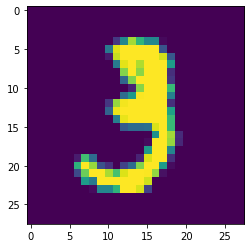

In [2]:
import urllib.request, urllib.parse, os.path, hashlib, gzip
from functools import reduce

def get_mnist_data(url, base_url='http://yann.lecun.com/exdb/mnist/'):
    path = os.path.join('./data/', hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(path):
        with open(path, 'rb') as f:
            dat = f.read()
    else:
        with urllib.request.urlopen(urllib.parse.urljoin(base_url, url)) as response:
            dat = response.read()

        with open(path, 'wb') as f:
            f.write(dat)

    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

size = (28, 28)
n_features, n_classes = np.prod(size), 10

X_train = get_mnist_data('train-images-idx3-ubyte.gz')[16:].reshape(-1, *size)
y_train = get_mnist_data('train-labels-idx1-ubyte.gz')[8:]
X_test = get_mnist_data('t10k-images-idx3-ubyte.gz')[16:].reshape(-1, *size)
y_test = get_mnist_data('t10k-labels-idx1-ubyte.gz')[8:]

# Test plot
plt.imshow(X_train[10]);

In [3]:
def gen_mini_batch(batch_size):
    idxs = np.random.randint(0, high=np.shape(X_train)[0], size=batch_size)
    return X_train[idxs].reshape((-1, n_features)), y_train[idxs]

def one_hot(xs, n_classes=10):
    ys = np.zeros((xs.shape[0], n_classes))
    for i, x in enumerate(xs):
        ys[i, x] = 1
        
    return ys

In [4]:
import alsograd.core as ag
from alsograd.nn.module import Module
from alsograd.nn.layers import Linear
from alsograd.nn.activations import *

class Net(Module):
    def __init__(self):
        super().__init__()

        self.l1 = Linear(n_features, 128)
        self.l2 = Linear(128, 32)
        self.l3 = Linear(32, 10)

    def forward(self, x):
        x = relu(self.l1(x))
        x = relu(self.l2(x))
        x = self.l3(x)

        return x

In [5]:
model = Net()

# Test inputs
x, y_true = np.random.rand(8, n_features), np.random.randint(0, 10, size=8)

# alsograd loss
y_pred = model.forward(ag.Parameter(x))
loss_ag = (-softmax(y_pred).log()*one_hot(y_true)).mean()*n_classes

# Torch loss
import torch
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
loss_th = criterion(torch.tensor(y_pred.data).float(), torch.tensor(y_true).long())

assert (loss_th - loss_ag.data[0]).abs() < 1e-5

In [6]:
from alsograd.nn.optimizer import SGD

# Train
def get_acc(y_pred, y):
    return (np.argmax(y_pred, axis=1) == y).mean()

batch_size = 1024
n_epoch, n_batches = 5, 100

optimizer = SGD(model, learning_rate=1e-4)

losses, accuracies = [], []
for _ in range(n_epoch):
    for _ in range(n_batches):
        images, labels = gen_mini_batch(batch_size)
        images, labels_oh = ag.Parameter(images), one_hot(labels)

        optimizer.zero_grad()

        y = model(images)
        acc = get_acc(y.data, labels)

        # Cross-entropy
        loss = (-softmax(y).log()*labels_oh).mean()*n_classes
        loss.backward()

        optimizer.step()

        # Process
        losses.append(loss)
        accuracies.append(acc)
        print('Loss: {:.3f}, acc: {:.3f}'.format(loss.data[0], acc), end="\r")

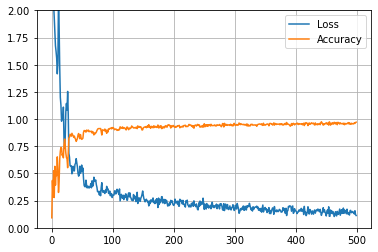

In [7]:
losses_np = [l.data[0] for l in losses]

plt.plot(losses_np, label='Loss')
plt.plot(accuracies, label='Accuracy')
plt.ylim([0, 2])
plt.legend()
plt.grid()